# Ref Score Generator
## Generates a score between 0-100 that can be used to determine whether a customer is a promoter or detractor

In [11]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from sklearn import model_selection
import sklearn

# Load the data

In [12]:
ref_data = pd.read_csv('ShareScore2 - Sheet1.csv') 

In [13]:
#Some basic data exploration
ref_data.head()

,Client Name,Last date of Update,Project Stage,Project Health,Project Stage Score,Project Stage Weightage,Duration,Duration Score,Duration Weightage,#Users,...,Level of Customization,Customization Score,Customization Weightage,Support Issue frequency,Support Issue frequency Score,Support Issue frequency weightage,Bills Outstanding,Bills Outstanding Score,Bills Outstanding weightage,Final Score
0,A,"31 Aug,2020",Steady state (>3months),NaN,1,9.09,1-2 years,2,7.272,1000 to 2000,...,Low,1,5.10,Low (once a month or less),1,9.090,0-15 days,1,10.09,89
1,B,"31 Aug,2020",Steady state (>3months),NaN,1,9.09,> 2 years,1,9.090,500 to 1000,...,Medium,2,4.08,Low (once a month or less),1,9.090,0-15 days,1,10.09,87
2,C,"31 Aug,2020",Steady state (>3months),NaN,1,9.09,1-2 years,2,7.272,100 to 200,...,Low,1,5.10,Low (once a month or less),1,9.090,0-15 days,1,10.09,87
3,D,"31 Aug,2020",Steady state (>3months),NaN,1,9.09,1-2 years,2,7.272,500 to 1000,...,Low,1,5.10,Medium( 2-5 per month),2,7.272,0-15 days,1,10.09,87
4,E,"31 Aug,2020",Steady state (>3months),NaN,1,9.09,> 2 years,1,9.090,500 to 1000,...,Low,1,5.10,Low (once a month or less),1,9.090,0-15 days,1,10.09,86


In [14]:
#remove project health
ref_data.columns

Index(['Client Name', 'Last date of Update', 'Project Stage', 'Project Health',
       'Project Stage Score', 'Project Stage Weightage', 'Duration',
       'Duration Score', 'Duration Weightage', '#Users', '#Users Score',
       'Users Weightage', '#Topics launched', '#Topics launched Score',
       '#Topics Launched Weightage', '%Activation', '%Activation Score',
       '%Activation Weightage', '%Usage', '%Usage Score', '%Usage Weightage',
       'Topic Launch Frequency', 'Topic Frequency Score',
       'Topic Frequency Weightage', 'Review Meeting Frequency',
       'Meeting Frequency Score', 'Meeting Frequency Weightage',
       'Level of Customization', 'Customization Score',
       'Customization Weightage', 'Support Issue frequency',
       'Support Issue frequency Score', 'Support Issue frequency weightage',
       'Bills Outstanding', 'Bills Outstanding Score',
       'Bills Outstanding weightage', 'Final Score'],
      dtype='object')

In [15]:
ref_data.isnull().sum()

Client Name                           0
Last date of Update                   0
Project Stage                         0
Project Health                       39
Project Stage Score                   0
Project Stage Weightage               0
Duration                              0
Duration Score                        0
Duration Weightage                    0
#Users                                0
#Users Score                          0
Users Weightage                       0
#Topics launched                      0
#Topics launched Score                0
#Topics Launched Weightage            0
%Activation                           0
%Activation Score                     0
%Activation Weightage                 0
%Usage                                0
%Usage Score                          0
%Usage Weightage                      0
Topic Launch Frequency                0
Topic Frequency Score                 0
Topic Frequency Weightage             0
Review Meeting Frequency              0


# Get the latest date of update

In [16]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
cur_date = datetime.now().date()
latest_date = cur_date
#Months with 31 days
months_set1 = [1,3,5,7,8,10,12]
#All other months
months_set2 = [2,4,6,9,11]
#Case for all months except for february
if (cur_date.day < 30 and cur_date.month != 2) | (cur_date.day == 30 and cur_date.month in months_set1):
    latest_date = latest_date + relativedelta(months=-1)
    if latest_date.month in months_set1:
        latest_date = latest_date + relativedelta(day=31)
    elif latest_date.month in months_set2 and latest_date.month != 2:
        latest_date = latest_date + relativedelta(day=30)
    else:
        latest_date = latest_date + relativedelta(day=28)
#Case for February
elif cur_date.month == 2:
    if cur_date.month < 28:
        latest_date = latest_date + relativedelta(months=-1)
        latest_date = latest_date + relativedelta(day=31)
latest_date = latest_date.strftime('%Y-%m-%d')
cur_date = cur_date.strftime('%Y-%m-%d')
print(latest_date)

2020-08-31


# Creating Dataset for Generating Score Trends

In [17]:
#Create a separate dataset for generating score trend for a particular client
ref_data_copyt = ref_data.copy()
#Fix the incorrectly entered entries in the data
ref_data_copyt = ref_data_copyt.replace(to_replace=['2nd Sep', '2nd Sep 2020', '2nd Sep, 2020'] ,value='2 Sep,2020')
ref_data_copyt = ref_data_copyt.replace(to_replace='26 Aug, 2020' ,value='31 Aug,2020')

In [18]:
#Check to make sure values have been replaced correctly
ref_data_copyt['Last date of Update']

0     31 Aug,2020
1     31 Aug,2020
2     31 Aug,2020
3     31 Aug,2020
4     31 Aug,2020
5     31 Aug,2020
6     31 Aug,2020
7     31 Aug,2020
8     31 Aug,2020
9     31 Aug,2020
10    31 Aug,2020
11    31 Aug,2020
12    31 Aug,2020
13    31 Aug,2020
14    31 Aug,2020
15    31 Aug,2020
16    31 Aug,2020
17    31 Aug,2020
18    31 Aug,2020
19     2 Sep,2020
20    31 Aug,2020
21    31 Aug,2020
22    31 Aug,2020
23    31 Aug,2020
24    31 Aug,2020
25     2 Sep,2020
26    31 Aug,2020
27    31 Aug,2020
28     2 Sep,2020
29    31 Aug,2020
30     2 Sep,2020
31    31 Aug,2020
32     2 Sep,2020
33     2 Sep,2020
34     2 Sep,2020
35     2 Sep,2020
36     2 Sep,2020
37    30 Sep,2020
38    24 Oct,2020
Name: Last date of Update, dtype: object

In [19]:
#Helper function
def remove(string): 
    return "".join(string.split())

In [20]:
#Convert all values in the 'Last date of Update' to datetime and then string and exclude the timestamp. Output results.
for i in range(0, len(ref_data_copyt['Last date of Update'])):
    ref_data_copyt['Last date of Update'].iloc[i] = remove(ref_data_copyt['Last date of Update'].iloc[i])
    ref_data_copyt['Last date of Update'].iloc[i] = datetime.strptime(ref_data_copyt['Last date of Update'].iloc[i], '%d%b,%Y')
    ref_data_copyt['Last date of Update'].iloc[i] = ref_data_copyt['Last date of Update'].iloc[i].strftime('%Y-%m-%d')
ref_data_copyt['Last date of Update']

/Users/ojasbardiya/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


0     2020-08-31
1     2020-08-31
2     2020-08-31
3     2020-08-31
4     2020-08-31
5     2020-08-31
6     2020-08-31
7     2020-08-31
8     2020-08-31
9     2020-08-31
10    2020-08-31
11    2020-08-31
12    2020-08-31
13    2020-08-31
14    2020-08-31
15    2020-08-31
16    2020-08-31
17    2020-08-31
18    2020-08-31
19    2020-09-02
20    2020-08-31
21    2020-08-31
22    2020-08-31
23    2020-08-31
24    2020-08-31
25    2020-09-02
26    2020-08-31
27    2020-08-31
28    2020-09-02
29    2020-08-31
30    2020-09-02
31    2020-08-31
32    2020-09-02
33    2020-09-02
34    2020-09-02
35    2020-09-02
36    2020-09-02
37    2020-09-30
38    2020-10-24
Name: Last date of Update, dtype: object

In [21]:
#Check to make sure all values have been converted into the appropriate string format
ref_data_copyt

,Client Name,Last date of Update,Project Stage,Project Health,Project Stage Score,Project Stage Weightage,Duration,Duration Score,Duration Weightage,#Users,...,Level of Customization,Customization Score,Customization Weightage,Support Issue frequency,Support Issue frequency Score,Support Issue frequency weightage,Bills Outstanding,Bills Outstanding Score,Bills Outstanding weightage,Final Score
0,A,2020-08-31,Steady state (>3months),NaN,1,9.090,1-2 years,2,7.272,1000 to 2000,...,Low,1,5.10,Low (once a month or less),1,9.090,0-15 days,1,10.090,89
1,B,2020-08-31,Steady state (>3months),NaN,1,9.090,> 2 years,1,9.090,500 to 1000,...,Medium,2,4.08,Low (once a month or less),1,9.090,0-15 days,1,10.090,87
2,C,2020-08-31,Steady state (>3months),NaN,1,9.090,1-2 years,2,7.272,100 to 200,...,Low,1,5.10,Low (once a month or less),1,9.090,0-15 days,1,10.090,87
3,D,2020-08-31,Steady state (>3months),NaN,1,9.090,1-2 years,2,7.272,500 to 1000,...,Low,1,5.10,Medium( 2-5 per month),2,7.272,0-15 days,1,10.090,87
4,E,2020-08-31,Steady state (>3months),NaN,1,9.090,> 2 years,1,9.090,500 to 1000,...,Low,1,5.10,Low (once a month or less),1,9.090,0-15 days,1,10.090,86
5,F,2020-08-31,Steady state (>3months),NaN,1,9.090,1-2 years,2,7.272,500 to 1000,...,Low,1,5.10,Low (once a month or less),1,9.090,0-15 days,1,10.090,84
6,G,2020-08-31,Steady state (>3months),NaN,1,9.090,1-2 years,2,7.272,5000 to 10000,...,Low,1,5.10,Medium( 2-5 per month),2,7.272,0-15 days,1,10.090,84
7,H,2020-08-31,Steady state (>3months),NaN,1,9.090,1-2 years,2,7.272,5000 to 10000,...,Low,1,5.10,Low (once a month or less),1,9.090,0-15 days,1,10.090,83
8,I,2020-08-31,Steady state (>3months),NaN,1,9.090,1-2 years,2,7.272,200 to 500,...,Low,1,5.10,Low (once a month or less),1,9.090,0-15 days,1,10.090,83
9,J,2020-08-31,Steady state (>3months),NaN,1,9.090,1-2 years,2,7.272,5000 to 10000,...,Low,1,5.10,Medium( 2-5 per month),2,7.272,0-15 days,1,10.090,82


# Determining Final Set of Data$^{1}$ for -
* Creating Basic and Advanced data visualizations
* Modelling the data to predict Ref Score

1.Categorized as the set of data between the last date of the previous month and the present date

In [22]:
ref_data = ref_data_copyt[(ref_data_copyt['Last date of Update'] >= latest_date) & (ref_data_copyt['Last date of Update'] <= cur_date)]
ref_data

,Client Name,Last date of Update,Project Stage,Project Health,Project Stage Score,Project Stage Weightage,Duration,Duration Score,Duration Weightage,#Users,...,Level of Customization,Customization Score,Customization Weightage,Support Issue frequency,Support Issue frequency Score,Support Issue frequency weightage,Bills Outstanding,Bills Outstanding Score,Bills Outstanding weightage,Final Score
0,A,2020-08-31,Steady state (>3months),NaN,1,9.090,1-2 years,2,7.272,1000 to 2000,...,Low,1,5.10,Low (once a month or less),1,9.090,0-15 days,1,10.090,89
1,B,2020-08-31,Steady state (>3months),NaN,1,9.090,> 2 years,1,9.090,500 to 1000,...,Medium,2,4.08,Low (once a month or less),1,9.090,0-15 days,1,10.090,87
2,C,2020-08-31,Steady state (>3months),NaN,1,9.090,1-2 years,2,7.272,100 to 200,...,Low,1,5.10,Low (once a month or less),1,9.090,0-15 days,1,10.090,87
3,D,2020-08-31,Steady state (>3months),NaN,1,9.090,1-2 years,2,7.272,500 to 1000,...,Low,1,5.10,Medium( 2-5 per month),2,7.272,0-15 days,1,10.090,87
4,E,2020-08-31,Steady state (>3months),NaN,1,9.090,> 2 years,1,9.090,500 to 1000,...,Low,1,5.10,Low (once a month or less),1,9.090,0-15 days,1,10.090,86
5,F,2020-08-31,Steady state (>3months),NaN,1,9.090,1-2 years,2,7.272,500 to 1000,...,Low,1,5.10,Low (once a month or less),1,9.090,0-15 days,1,10.090,84
6,G,2020-08-31,Steady state (>3months),NaN,1,9.090,1-2 years,2,7.272,5000 to 10000,...,Low,1,5.10,Medium( 2-5 per month),2,7.272,0-15 days,1,10.090,84
7,H,2020-08-31,Steady state (>3months),NaN,1,9.090,1-2 years,2,7.272,5000 to 10000,...,Low,1,5.10,Low (once a month or less),1,9.090,0-15 days,1,10.090,83
8,I,2020-08-31,Steady state (>3months),NaN,1,9.090,1-2 years,2,7.272,200 to 500,...,Low,1,5.10,Low (once a month or less),1,9.090,0-15 days,1,10.090,83
9,J,2020-08-31,Steady state (>3months),NaN,1,9.090,1-2 years,2,7.272,5000 to 10000,...,Low,1,5.10,Medium( 2-5 per month),2,7.272,0-15 days,1,10.090,82


### Note: 
* ref_data refers to the main dataset used for modelling Ref Score and Basic/Advanced data visualization.
* ref_data_copyt refers to the dataset used to visualize trends in Ref Score for a certain customer

# Basic Data Visualization

In [23]:
import matplotlib.patches as mpatches

In [76]:
#color code for all 
green_patch = mpatches.Patch(color='green', label='1-Best')
red_patch = mpatches.Patch(color='red', label='5-Worst')
blue_patch = mpatches.Patch(color='blue', label='2-4 Average')

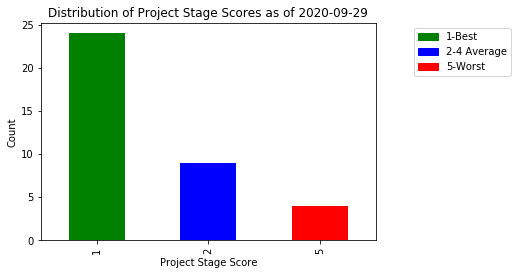

In [84]:
ref_data.groupby('Project Stage Score')['Project Stage Score'].agg('count').plot(kind='bar', color=('green','blue', 'red', 'blue', 'red'))
plt.title('Distribution of Project Stage Scores as of {}'.format(cur_date))
plt.ylabel('Count')
plt.legend(handles=[green_patch, blue_patch ,red_patch], bbox_to_anchor=(1.1,1), loc='upper left')

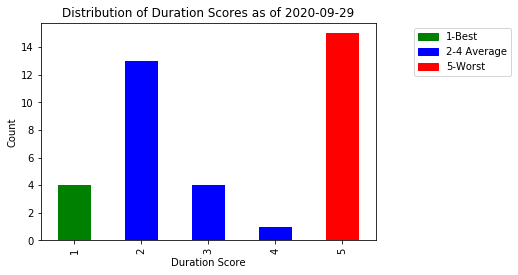

In [85]:
ref_data.groupby('Duration Score')['Duration Score'].agg('count').plot(kind='bar', color=('green','blue', 'blue', 'blue', 'red'))
plt.title('Distribution of Duration Scores as of {}'.format(cur_date))
plt.ylabel('Count')
plt.legend(handles=[green_patch, blue_patch ,red_patch], bbox_to_anchor=(1.1,1), loc='upper left')

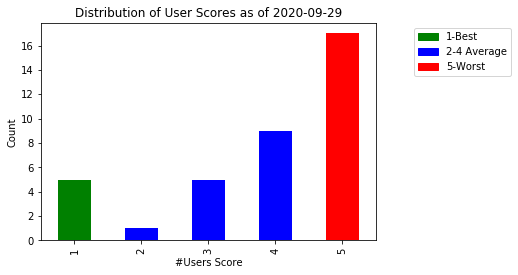

In [86]:
ref_data.groupby('#Users Score')['#Users Score'].agg('count').plot(kind='bar', color=('green','blue', 'blue', 'blue', 'red'))
plt.title('Distribution of User Scores as of {}'.format(cur_date))
plt.ylabel('Count')
plt.legend(handles=[green_patch, blue_patch ,red_patch], bbox_to_anchor=(1.1,1), loc='upper left')

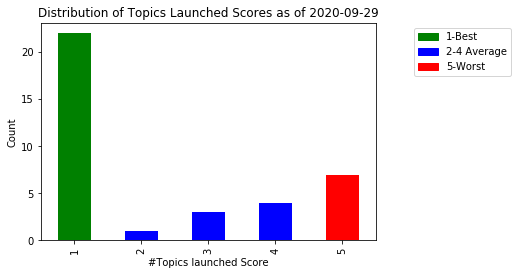

In [87]:
ref_data.groupby('#Topics launched Score')['#Topics launched Score'].agg('count').plot(kind='bar', color=('green','blue', 'blue', 'blue', 'red'))
plt.title('Distribution of Topics Launched Scores as of {}'.format(cur_date))
plt.ylabel('Count')
plt.legend(handles=[green_patch, blue_patch ,red_patch], bbox_to_anchor=(1.1,1), loc='upper left')

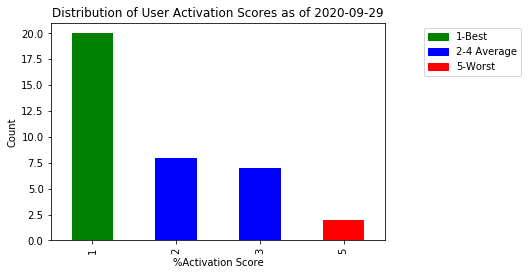

In [88]:
ref_data.groupby('%Activation Score')['%Activation Score'].agg('count').plot(kind='bar', color=('green','blue', 'blue', 'red', 'red'))
plt.title('Distribution of User Activation Scores as of {}'.format(cur_date))
plt.ylabel('Count')
plt.legend(handles=[green_patch, blue_patch ,red_patch], bbox_to_anchor=(1.1,1), loc='upper left')

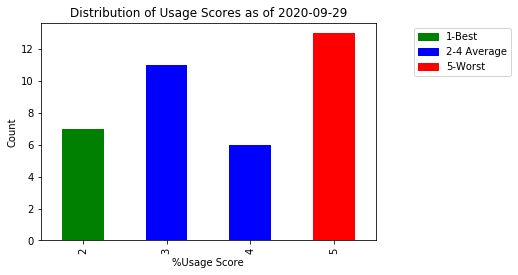

In [89]:
ref_data.groupby('%Usage Score')['%Usage Score'].agg('count').plot(kind='bar', color=('green','blue', 'blue', 'red', 'red'))
plt.title('Distribution of Usage Scores as of {}'.format(cur_date))
plt.ylabel('Count')
plt.legend(handles=[green_patch, blue_patch ,red_patch], bbox_to_anchor=(1.1,1), loc='upper left')

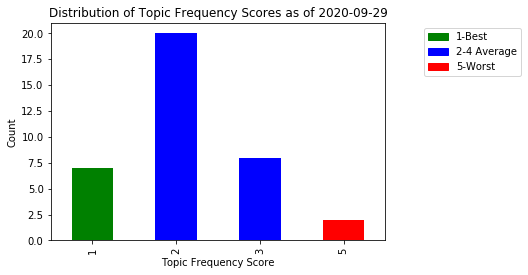

In [90]:
ref_data.groupby('Topic Frequency Score')['Topic Frequency Score'].agg('count').plot(kind='bar', color=('green','blue', 'blue', 'red', 'red'))
plt.title('Distribution of Topic Frequency Scores as of {}'.format(cur_date))
plt.ylabel('Count')
plt.legend(handles=[green_patch, blue_patch ,red_patch], bbox_to_anchor=(1.1,1), loc='upper left')

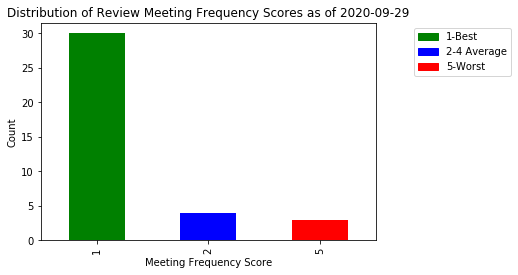

In [91]:
ref_data.groupby('Meeting Frequency Score')['Meeting Frequency Score'].agg('count').plot(kind='bar', color=('green','blue', 'red', 'blue', 'red'))
plt.title('Distribution of Review Meeting Frequency Scores as of {}'.format(cur_date))
plt.ylabel('Count')
plt.legend(handles=[green_patch, blue_patch ,red_patch], bbox_to_anchor=(1.1,1), loc='upper left')

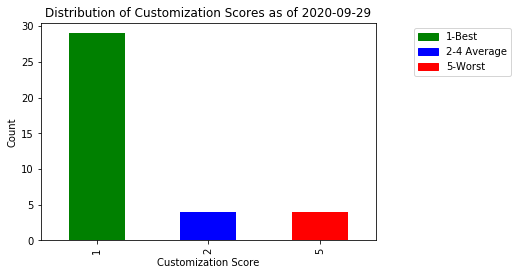

In [92]:
ref_data.groupby('Customization Score')['Customization Score'].agg('count').plot(kind='bar', color=('green','blue', 'red', 'blue', 'red'))
plt.title('Distribution of Customization Scores as of {}'.format(cur_date))
plt.ylabel('Count')
plt.legend(handles=[green_patch, blue_patch ,red_patch], bbox_to_anchor=(1.1,1), loc='upper left')

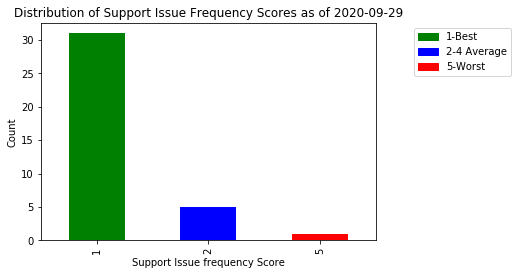

In [93]:
ref_data.groupby('Support Issue frequency Score')['Support Issue frequency Score'].agg('count').plot(kind='bar', color=('green','blue', 'red', 'blue', 'red'))
plt.title('Distribution of Support Issue Frequency Scores as of {}'.format(cur_date))
plt.ylabel('Count')
plt.legend(handles=[green_patch, blue_patch ,red_patch], bbox_to_anchor=(1.1,1), loc='upper left')

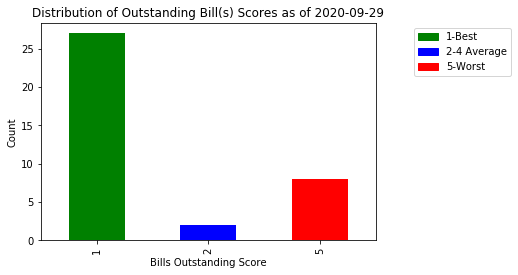

In [94]:
ref_data.groupby('Bills Outstanding Score')['Bills Outstanding Score'].agg('count').plot(kind='bar', color=('green','blue', 'red', 'blue', 'red'))
plt.title('Distribution of Outstanding Bill(s) Scores as of {}'.format(cur_date))
plt.ylabel('Count')
plt.legend(handles=[green_patch, blue_patch ,red_patch], bbox_to_anchor=(1.1,1), loc='upper left')

Text(0.5, 1.0, 'Distribution of Ref scores as of 2020-09-29')

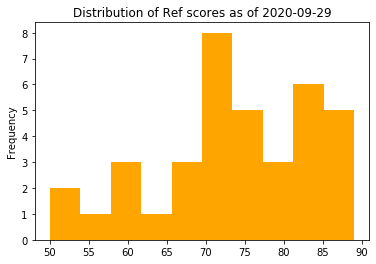

In [95]:
ref_data['Final Score'].plot(kind='hist', color='orange')
plt.title('Distribution of Ref scores as of {}'.format(cur_date))

Text(0.5, 1.0, 'Distribution of customer types according to Ref score as of 2020-09-29')

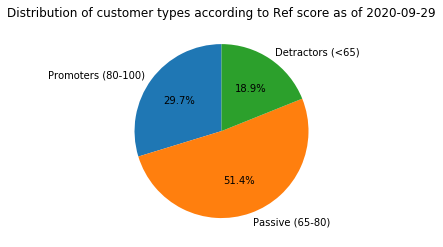

In [96]:
col = ref_data['Final Score']
promoters = col[col >= 80]
passive = col[(col >= 65) & (col < 80)]
detractors = col[col < 65]
customer_counts = [len(promoters), len(passive), len(detractors)]
customer_types = ['Promoters (80-100)', 'Passive (65-80)', 'Detractors (<65)']
plt.pie(customer_counts, labels=customer_types, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of customer types according to Ref score as of {}'.format(cur_date))

In [38]:
#Get the mean/median
print('Mean score: ', ref_data['Final Score'].mean())
print('Median score: ', ref_data['Final Score'].median())

Mean score:  73.8108108108108
Median score:  74.0


# Advanced Visualization

## Project stage vs Duration

Text(0.5, 0, 'Count')

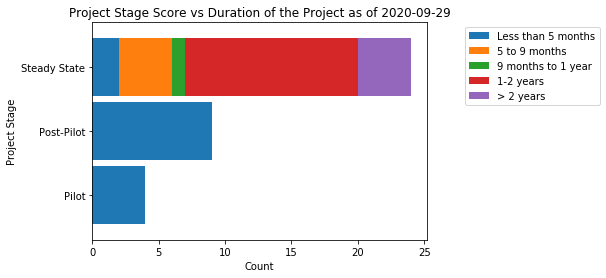

In [39]:
ref_data_copy1 = ref_data.copy()
#less than 2 months and 2-5 months are both allotted a score of 5 so we assign a commmon value for them
ref_data_copy1.Duration = ref_data_copy1.Duration.replace({"Less than 2 months": "Less than 5 months", "2 to 5 months":"Less than 5 months"})
#change wording of some values
ref_data_copy1['Project Stage'] = ref_data_copy1['Project Stage'].map({"Steady state (>3months)":"Steady State", "1-2 months Post Pilot":"Post-Pilot", "Pilot":"Pilot"})
score_counts = pd.crosstab(ref_data_copy1['Project Stage'], ref_data_copy1['Duration'])
#plot the resulting figure
groups=['Less than 5 months', '5 to 9 months', '9 months to 1 year', '1-2 years', '> 2 years']
score_counts.columns = pd.CategoricalIndex(score_counts.columns.values, ordered=True, categories=groups)
score_counts = score_counts.sort_index(axis=1)
ax = score_counts.plot.barh(width=0.9, stacked=True)
ax.set_title('Project Stage Score vs Duration of the Project as of {}'.format(cur_date))
ax.legend(bbox_to_anchor=(1.1,1), loc='upper left')
ax.set_xlabel('Count')

## Topics vs Usage

Text(0.5, 0, 'Count')

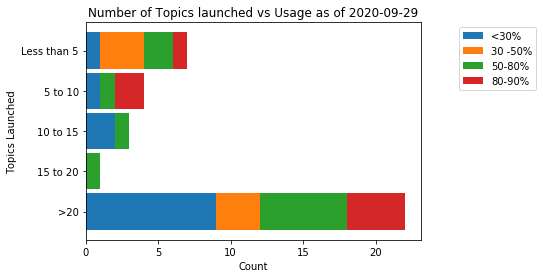

In [40]:
ref_data_copy2 = ref_data.copy()
usage_counts = pd.crosstab(ref_data_copy2['#Topics launched'], ref_data_copy2['%Usage'])
y_indices = ['>20', '15 to 20', '10 to 15', '5 to 10', 'Less than 5']
groups=['<30%', '30 -50%', '50-80%', '80-90%']
usage_counts.columns = pd.CategoricalIndex(usage_counts.columns.values, ordered=True, categories=groups)
usage_counts = usage_counts.sort_index(axis=1)
ax = usage_counts.reindex(y_indices).plot.barh(width=0.9, stacked=True)
ax.set_title('Number of Topics launched vs Usage as of {}'.format(cur_date))
ax.set_ylabel('Topics Launched')
ax.legend(bbox_to_anchor=(1.1,1), loc='upper left')
ax.set_xlabel('Count')

## Topic Frequency vs Usage

Text(0.5, 0, 'Count')

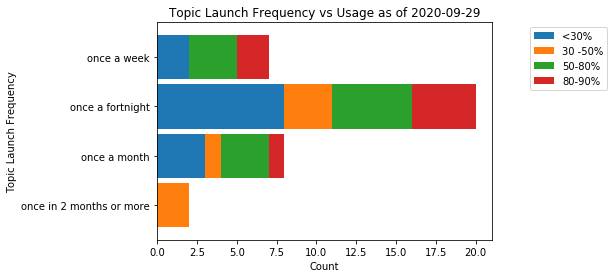

In [41]:
ref_data_copy3 = ref_data.copy()
usage_counts = pd.crosstab(ref_data_copy3['Topic Launch Frequency'], ref_data_copy3['%Usage'])
y_indices = ['once a week', 'once a fortnight', 'once a month', 'once in 2 months or more']
groups=['<30%', '30 -50%', '50-80%', '80-90%']
usage_counts.columns = pd.CategoricalIndex(usage_counts.columns.values, ordered=True, categories=groups)
usage_counts = usage_counts.sort_index(axis=1)
ax = usage_counts.reindex(reversed(y_indices)).plot.barh(width=0.9, stacked=True)
ax.set_title('Topic Launch Frequency vs Usage as of {}'.format(cur_date))
ax.legend(bbox_to_anchor=(1.1,1), loc='upper left')
ax.set_xlabel('Count')

## Duration vs Users

Text(0.5, 0, 'Count')

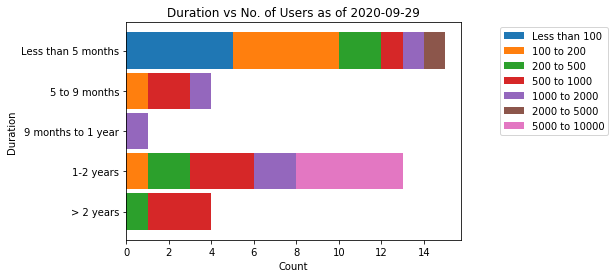

In [42]:
ref_data_copy4 = ref_data.copy()
ref_data_copy4.Duration = ref_data_copy4.Duration.replace({"Less than 2 months": "Less than 5 months", "2 to 5 months":"Less than 5 months"})
user_counts = pd.crosstab(ref_data_copy4['Duration'], ref_data_copy4['#Users'])
y_indices = ['Less than 5 months', '5 to 9 months', '9 months to 1 year', '1-2 years', '> 2 years']
groups=['Less than 100', '100 to 200', '200 to 500', '500 to 1000', '1000 to 2000', '2000 to 5000', '5000 to 10000']
user_counts.columns = pd.CategoricalIndex(user_counts.columns.values, ordered=True, categories=groups)
user_counts = user_counts.sort_index(axis=1)
ax = user_counts.reindex(reversed(y_indices)).plot.barh(width=0.9, stacked=True)
ax.set_title('Duration vs No. of Users as of {}'.format(cur_date))
ax.legend(bbox_to_anchor=(1.1,1), loc='upper left')
ax.set_xlabel('Count')

# Data Wrangling 

In [43]:
#Add a column for customer category based on Ref score
def customer_category(row):
    if row['Final Score'] >= 80:
        return 'Promoter'
    elif row['Final Score'] >= 65:
        return 'Passive'
    else:
        return 'Detractor'

In [44]:
#Apply the function and store the returned values
categories = ref_data.apply(lambda row: customer_category(row), axis=1)
categories

0      Promoter
1      Promoter
2      Promoter
3      Promoter
4      Promoter
5      Promoter
6      Promoter
7      Promoter
8      Promoter
9      Promoter
10     Promoter
11      Passive
12      Passive
13      Passive
14      Passive
15      Passive
16      Passive
17      Passive
18      Passive
19      Passive
20      Passive
21      Passive
22      Passive
23      Passive
24      Passive
25      Passive
26      Passive
27      Passive
28      Passive
29      Passive
30    Detractor
31    Detractor
32    Detractor
33    Detractor
34    Detractor
35    Detractor
36    Detractor
dtype: object

In [45]:
#Add the new column to the main dataframe
ref_data['Customer Category'] = categories

/Users/ojasbardiya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [46]:
#check
ref_data.head(10)

,Client Name,Last date of Update,Project Stage,Project Health,Project Stage Score,Project Stage Weightage,Duration,Duration Score,Duration Weightage,#Users,...,Customization Score,Customization Weightage,Support Issue frequency,Support Issue frequency Score,Support Issue frequency weightage,Bills Outstanding,Bills Outstanding Score,Bills Outstanding weightage,Final Score,Customer Category
0,A,2020-08-31,Steady state (>3months),NaN,1,9.09,1-2 years,2,7.272,1000 to 2000,...,1,5.10,Low (once a month or less),1,9.090,0-15 days,1,10.09,89,Promoter
1,B,2020-08-31,Steady state (>3months),NaN,1,9.09,> 2 years,1,9.090,500 to 1000,...,2,4.08,Low (once a month or less),1,9.090,0-15 days,1,10.09,87,Promoter
2,C,2020-08-31,Steady state (>3months),NaN,1,9.09,1-2 years,2,7.272,100 to 200,...,1,5.10,Low (once a month or less),1,9.090,0-15 days,1,10.09,87,Promoter
3,D,2020-08-31,Steady state (>3months),NaN,1,9.09,1-2 years,2,7.272,500 to 1000,...,1,5.10,Medium( 2-5 per month),2,7.272,0-15 days,1,10.09,87,Promoter
4,E,2020-08-31,Steady state (>3months),NaN,1,9.09,> 2 years,1,9.090,500 to 1000,...,1,5.10,Low (once a month or less),1,9.090,0-15 days,1,10.09,86,Promoter
5,F,2020-08-31,Steady state (>3months),NaN,1,9.09,1-2 years,2,7.272,500 to 1000,...,1,5.10,Low (once a month or less),1,9.090,0-15 days,1,10.09,84,Promoter
6,G,2020-08-31,Steady state (>3months),NaN,1,9.09,1-2 years,2,7.272,5000 to 10000,...,1,5.10,Medium( 2-5 per month),2,7.272,0-15 days,1,10.09,84,Promoter
7,H,2020-08-31,Steady state (>3months),NaN,1,9.09,1-2 years,2,7.272,5000 to 10000,...,1,5.10,Low (once a month or less),1,9.090,0-15 days,1,10.09,83,Promoter
8,I,2020-08-31,Steady state (>3months),NaN,1,9.09,1-2 years,2,7.272,200 to 500,...,1,5.10,Low (once a month or less),1,9.090,0-15 days,1,10.09,83,Promoter
9,J,2020-08-31,Steady state (>3months),NaN,1,9.09,1-2 years,2,7.272,5000 to 10000,...,1,5.10,Medium( 2-5 per month),2,7.272,0-15 days,1,10.09,82,Promoter


In [47]:
#creating the final dataset for applying the model
ref_data_final = ref_data[['Project Stage Score', 'Duration Score', '#Users Score', '#Topics launched Score', '%Activation Score','%Usage Score', 'Topic Frequency Score','Meeting Frequency Score','Customization Score','Support Issue frequency Score', 'Bills Outstanding Score', 'Customer Category']]

In [48]:
#Validate the data -- make sure weightages for each parameter total up to 100
weight_data = pd.read_csv('ShareScore - Sheet2.csv')
weight_scores = weight_data['Weightage %']
total_sum = weight_scores.agg('sum')
if total_sum != 100:
    print('ERROR: Weightages given to various parameters must total up to 100')

# Random Forest Model

In [49]:
#Set up the data
X = ref_data_final.drop('Customer Category', axis=1)
Y = ref_data_final['Customer Category']

In [50]:
#Split the data
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=40)

In [57]:
#Applying the Random forest model
from sklearn.ensemble import RandomForestClassifier
rand_forest = RandomForestClassifier(max_features=11,max_depth=4,n_estimators=25)

In [58]:
rand_forest.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features=11, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [59]:
rand_forest.score(X_test, Y_test)

0.75

### Due to the sample size of the dataset, the Random Forest Model cannot obtain an accuracy of > 85%, even with changing parameter values

# Multiple Regression Model

In [60]:
#Set up the response variable
Y2 = ref_data['Final Score']

In [61]:
#split the data
from sklearn.model_selection import train_test_split
X_train,X_test,Y2_train,Y2_test=train_test_split(X,Y2,test_size=0.3,random_state=42)

In [62]:
#Perform the multiple Regression
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,Y2_train)
lr_clf.score(X_test,Y2_test)

0.9989627018480327

# K-Nearest Neighbors

In [63]:
#Set up the response variable
Y3 = ref_data['Customer Category']

In [64]:
#split the data
from sklearn.model_selection import train_test_split
X_train,X_test,Y3_train,Y3_test=train_test_split(X,Y3,test_size=0.3,random_state=42)

In [65]:
#Perform the K-nearest neighbors algorithm
from sklearn.neighbors import KNeighborsClassifier

test_scores = []
train_scores = []

for i in range (1, 12):
    KNN = KNeighborsClassifier(i)
    KNN.fit(X_train,Y3_train)
    
    train_scores.append(KNN.score(X_train,Y3_train))
    test_scores.append(KNN.score(X_test,Y3_test))

Text(0.5, 1.0, 'Comparing Training and Test Data Accuracy')

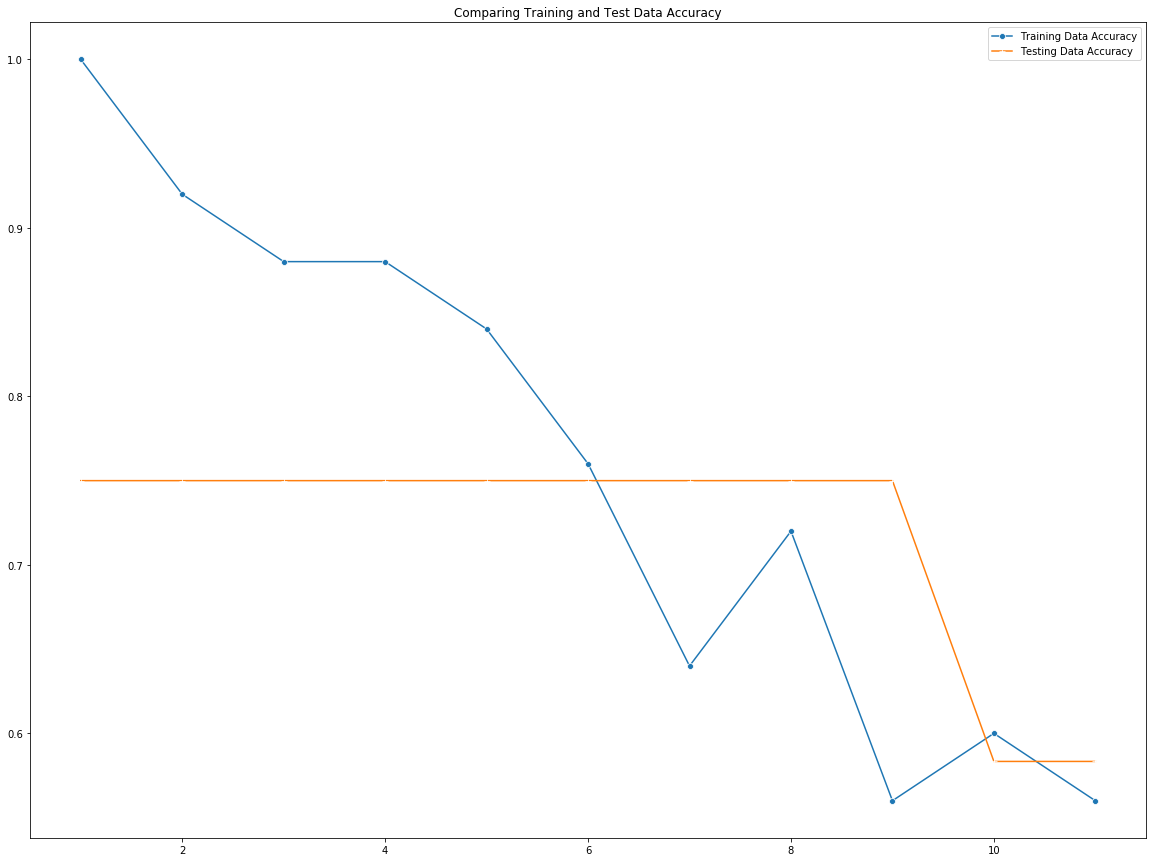

In [66]:
#Plot the training vs test error rate to determine the level of flexibility
plt.figure(figsize=(20,15))
final_plot = sns.lineplot(range(1,12),train_scores,marker='o',label='Training Data Accuracy')
final_plot = sns.lineplot(range(1,12),test_scores,marker='+',label='Testing Data Accuracy')
plt.title('Comparing Training and Test Data Accuracy')

In [67]:
print(max(test_scores))

0.75


In [68]:
#Perform the KNN Classification Algorithm with K = 6
KNN = KNeighborsClassifier(6)

KNN.fit(X_train,Y3_train)
KNN.score(X_test,Y3_test)

0.75

## Confusion Matrix

In [69]:
#Describe the performance of the K-nearest neighbors classifier
from sklearn.metrics import confusion_matrix
Y3_pred = KNN.predict(X_test)
confusion_matrix(Y3_test, Y3_pred)

array([[1, 0, 0],
       [0, 5, 3],
       [0, 0, 3]])

In [70]:
#Visualization of confusion matrix
pd.crosstab(Y3_test, Y3_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Detractor,Passive,Promoter,All
True,,,,
Detractor,1,0,0,1
Passive,0,5,3,8
Promoter,0,0,3,3
All,1,5,6,12


## Hyperparameter Tuning

In [71]:
#Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
param_grid = {'n_neighbors':np.arange(1,20)}
KNN = KNeighborsClassifier()
KNN_cv= GridSearchCV(KNN,param_grid,cv=5)
KNN_cv.fit(X,Y3)

/Users/ojasbardiya/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [72]:
#Print out the values of highest test accuracy and value of K for which it happens
print(KNN_cv.best_score_, KNN_cv.best_params_)

0.7837837837837838 {'n_neighbors': 2}


# Score Trend Generator

In [73]:
#Main function to generate line pot for Ref Scores for a particular client
def score_trend_generator(client_name):
    df = ref_data_copyt[ref_data_copyt['Client Name'] == 'A']
    df = df[['Last date of Update', 'Final Score']]
    ticklabels = df['Last date of Update'].values
    x_values = np.array(range(0, len(ticklabels)))
    y_values = df['Final Score'].values
    plt.xticks(x_values, ticklabels)
    plt.plot(x_values, y_values)
    plt.xlabel('Date')
    plt.ylabel('Ref Score')
    plt.title('Trend in Ref Score for client {}'.format(client_name))
    plt.show()
    

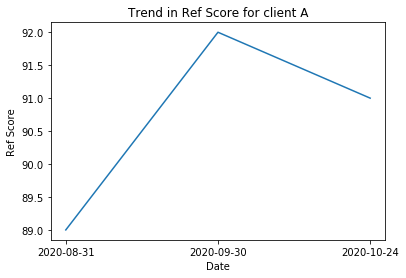

In [74]:
#Test case
x = score_trend_generator('A')
x

### Note: 
Two entries for the test case (specifically those on 2020-09-30 and 2020-10-24) are dummy values and can be discarded while evaluating the actual data